In [80]:
# import libraries, set random seed for reproducibility
# recommended TensorFlow version >= 1.12.0
# recommended Python version >= 3.5

# if libraries are missing:
# !pip install h5py
# !pip install matplotlib
# !pip install numpy
# !pip install pandas
# !pip install seaborn
# !pip install sklearn
# !pip install tensorflow
# !pip install tqdm

import os
import platform
import random
import shutil
import sys

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import sklearn.metrics
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split


from keras import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

random.seed(0)

print("TensorFlow", tf.__version__)
print("Python", platform.sys.version)

TensorFlow 1.13.1
Python 3.7.1 (v3.7.1:260ec2c36a, Oct 20 2018, 03:13:28) 
[Clang 6.0 (clang-600.0.57)]


In [81]:
X = pd.read_csv('drug_properties_final.csv', header=0, usecols=range(1,16))
print(X.head(5))
nsamples, nfts = X.shape
print(nsamples)
print(nfts)

     0    1    2      3    4           5    6    7     8    9     10  \
0  1.0  0.0  0.0  734.0  1.0  344.089603  7.0  3.0  25.0  0.0  344.3   
1  1.0  0.0  0.0  633.0  1.0  354.183109  4.0  1.0  26.0  0.0  354.4   
2  1.0  0.0  0.0  497.0  1.0  292.121178  3.0  1.0  22.0  0.0  292.3   
3  0.0  0.0  0.0  780.0  1.0  518.194068  8.0  6.0  38.0  0.0  518.6   
4  2.0  0.0  0.0  415.0  1.0  301.179027  3.0  3.0  22.0  0.0  301.4   

           11   12     13   14  
0  344.089603  2.0  121.0  2.1  
1  354.183109  8.0   71.4  4.4  
2  292.121178  1.0   52.9  2.4  
3  518.194068  5.0  156.0  6.9  
4  301.179027  2.0   68.4  2.3  
1784
15


In [82]:
drugs = pd.read_csv('drug_name_list_final.csv', header=0, usecols=range(1,2))
#drugs

In [83]:
drugs_with_resp_auc_data = pd.read_csv('drugs.csv', usecols = range(1,2))
#drugs_with_resp_auc_data

In [84]:
#idx = [drugs_with_resp_auc_data.index[drugs_with_resp_auc_data.iloc[:,0] == x] for x in drugs.iloc[:,0]]
# do some shady business getting the proper indexes- not everything was retrievable from pubchem
indexes = []
counter = 0
for drug in drugs_with_resp_auc_data.iloc[:,0]:
    if drug in list(drugs.iloc[:,0]):
        indexes.append(counter)
    counter = counter + 1
indexes

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 15,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 19

In [85]:
# get values for auc and maxrep
auc_values = pd.read_csv('auc.csv')
auc_values = auc_values.iloc[:,1:7]
print(auc_values.head(5))
maxresp_values = pd.read_csv('max_resp.csv')
maxresp_values = maxresp_values.iloc[:,1:7]
print(maxresp_values.head(5))

         0        1        2        3        4        5
0  428.792  460.119  277.164  443.183  408.479  408.348
1  466.491  494.689  477.969  580.252  445.541  490.083
2  413.997  261.922  438.649  360.282  417.510  322.348
3  473.658  514.225  391.226  472.357  455.033  483.530
4  499.085  454.862  284.317  498.955  490.830  436.067
         0        1       2        3       4        5
0   31.627   50.723  39.010   62.477  53.749   73.943
1  104.528  106.693  94.311  120.259  79.373  105.277
2   94.854   15.955  91.379   82.129  87.158   66.432
3   63.828   74.488  49.955  101.986  88.269   92.542
4    5.796    8.253  14.334   89.583  72.228   47.565


In [86]:
final_drugs = drugs_with_resp_auc_data.iloc[indexes,0]
final_drugs

final_auc = auc_values.iloc[indexes,:]
print(final_auc)

final_maxresp = maxresp_values.iloc[indexes,:]
print(final_maxresp)

            0        1        2        3        4        5
1     466.491  494.689  477.969  580.252  445.541  490.083
2     413.997  261.922  438.649  360.282  417.510  322.348
3     473.658  514.225  391.226  472.357  455.033  483.530
4     499.085  454.862  284.317  498.955  490.830  436.067
5     439.192  464.651  441.677  496.490  482.966  438.622
6     444.042  507.567  487.697  473.677  337.470  371.668
7     453.739  466.528  386.022  412.972  410.137  422.828
8     248.701  322.929  362.261  299.505  290.917  273.682
9     468.376  456.636  207.428  425.188  439.731  444.202
10    479.920  458.372  234.410  453.171  445.012  474.465
11    508.541  501.774  476.485  556.192  478.471  528.478
12    460.677  481.198  486.335  474.319  432.789  458.532
13    558.791  529.796  526.594  572.759  547.693  529.938
15    480.426  496.298  475.607  581.248  548.532  409.708
18    285.296  321.411  320.884  356.004  298.973  286.425
19    471.813  514.940  478.022  561.303  495.328  498.6

In [87]:
# fix the bad things if they exist
X[X==np.inf]=np.nan
np.where(X.values >= np.finfo(np.float32).max)
X = np.nan_to_num(X)

# check data for bad things in there
print(sum(np.isnan(X)))
print(sum(X > 10000))
print(sum(np.isinf(X)))
X

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until


array([[  1. ,   0. ,   0. , ...,   2. , 121. ,   2.1],
       [  1. ,   0. ,   0. , ...,   8. ,  71.4,   4.4],
       [  1. ,   0. ,   0. , ...,   1. ,  52.9,   2.4],
       ...,
       [  8. ,   0. ,   0. , ...,   4. , 122. ,   3.2],
       [  0. ,   0. ,   0. , ...,   6. ,  77.3,   6.5],
       [  4. ,   0. ,   0. , ...,   6. ,  71. ,   0. ]])

In [88]:
print(sum(np.isnan(X)))
print(sum(X > 10000))
print(sum(np.isinf(X)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [90]:
# and remove the nans in the other frames
#print(sum(np.isnan(final_auc)))
final_auc = np.nan_to_num(final_auc)
print(sum(np.isnan(final_auc)))

[0 0 0 0 0 0]


In [92]:
#print(sum(np.isnan(final_maxresp)))
final_maxresp = np.nan_to_num(final_maxresp)
print(sum(np.isnan(final_maxresp)))

[0 0 0 0 0 0]


In [ ]:
# need to scale values???

In [93]:
# Using Skicit-learn to split data into training and testing sets
# Split the data into training and testing sets
train_ft_auc, test_ft_auc, train_lab_auc, test_lab_auc = train_test_split(X, final_auc, test_size = 0.3, random_state = 0)
train_ft_resp, test_ft_resp, train_lab_resp, test_lab_resp = train_test_split(X, final_maxresp, test_size = 0.3, random_state = 0)


In [94]:
train_lab_auc.shape
final_auc.shape

(1784, 6)

In [ ]:
# code from here
# https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-regression-ceee5a9eadff
# https://datascienceplus.com/keras-regression-based-neural-networks/

In [98]:
def build_regressor():
    regressor = Sequential()
    regressor.add(Dense(units=15, input_dim=15, kernel_initializer='normal', activation='relu'))
    regressor.add(Dense(units=10, activation = 'relu'))
    regressor.add(Dense(units=6, activation = 'linear'))
    regressor.compile(optimizer='adam', loss='mse',  metrics=['mae', 'mse','accuracy'])
    return regressor

In [120]:
regressor = KerasRegressor(build_fn=build_regressor, batch_size=20,epochs=100)

In [121]:
results=regressor.fit(train_ft_auc,train_lab_auc)

Epoch 1/100
1248/1248 [==============================] - 0s 259us/step - loss: 186164.1274 - mean_absolute_error: 420.6378 - mean_squared_error: 186164.1274 - acc: 0.2324
Epoch 2/100
1248/1248 [==============================] - 0s 37us/step - loss: 106976.9447 - mean_absolute_error: 293.0100 - mean_squared_error: 106976.9447 - acc: 0.2348
Epoch 3/100
1248/1248 [==============================] - 0s 36us/step - loss: 58001.1198 - mean_absolute_error: 195.2173 - mean_squared_error: 58001.1198 - acc: 0.2115
Epoch 4/100
1248/1248 [==============================] - 0s 38us/step - loss: 45604.4462 - mean_absolute_error: 170.6472 - mean_squared_error: 45604.4462 - acc: 0.1418
Epoch 5/100
1248/1248 [==============================] - 0s 38us/step - loss: 41520.8840 - mean_absolute_error: 161.4088 - mean_squared_error: 41520.8840 - acc: 0.1595
Epoch 6/100
1248/1248 [==============================] - 0s 38us/step - loss: 40013.4602 - mean_absolute_error: 158.5680 - mean_squared_error: 40013.4602 -

1248/1248 [==============================] - 0s 37us/step - loss: 29841.8808 - mean_absolute_error: 136.6335 - mean_squared_error: 29841.8808 - acc: 0.4896
Epoch 50/100
1248/1248 [==============================] - 0s 35us/step - loss: 30024.8481 - mean_absolute_error: 137.9326 - mean_squared_error: 30024.8481 - acc: 0.4880
Epoch 51/100
1248/1248 [==============================] - 0s 35us/step - loss: 29716.3334 - mean_absolute_error: 136.9707 - mean_squared_error: 29716.3334 - acc: 0.4904
Epoch 52/100
1248/1248 [==============================] - 0s 37us/step - loss: 29637.2060 - mean_absolute_error: 136.3809 - mean_squared_error: 29637.2060 - acc: 0.4904
Epoch 53/100
1248/1248 [==============================] - 0s 38us/step - loss: 29512.6372 - mean_absolute_error: 136.4951 - mean_squared_error: 29512.6372 - acc: 0.4896
Epoch 54/100
1248/1248 [==============================] - 0s 35us/step - loss: 29368.4758 - mean_absolute_error: 135.0335 - mean_squared_error: 29368.4758 - acc: 0.4912

1248/1248 [==============================] - 0s 35us/step - loss: 26408.4936 - mean_absolute_error: 128.4446 - mean_squared_error: 26408.4936 - acc: 0.4936
Epoch 98/100
1248/1248 [==============================] - 0s 37us/step - loss: 26535.6177 - mean_absolute_error: 129.7130 - mean_squared_error: 26535.6177 - acc: 0.4936
Epoch 99/100
1248/1248 [==============================] - 0s 37us/step - loss: 26093.5844 - mean_absolute_error: 128.3169 - mean_squared_error: 26093.5844 - acc: 0.4936
Epoch 100/100
1248/1248 [==============================] - 0s 37us/step - loss: 25901.7739 - mean_absolute_error: 127.9309 - mean_squared_error: 25901.7739 - acc: 0.4936


In [122]:
y_pred= regressor.predict(test_ft_auc)

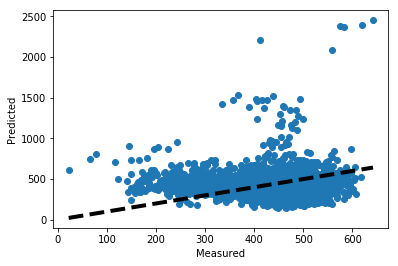

In [123]:
fig, ax = plt.subplots()
ax.scatter(test_lab_auc, y_pred)
ax.plot([test_lab_auc.min(), test_lab_auc.max()], [test_lab_auc.min(), test_lab_auc.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

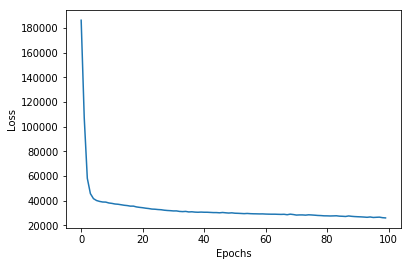

In [124]:
loss = results.history['loss']
#print(regressor.summary())
# let's plot the performance curve
plt.figure()
plt.plot(loss, label = 'loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

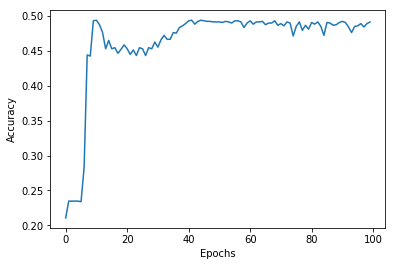

In [116]:
acc = results.history['acc']
#print(regressor.summary())
# let's plot the performance curve
plt.figure()
plt.plot(acc)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()